# Polder pumping station - machine learning tutorial
## Polder pumping station
Because a polder closely resembles a bath tub, it will slowly fill with water because of rainfall if it's not emptied by a pump. 
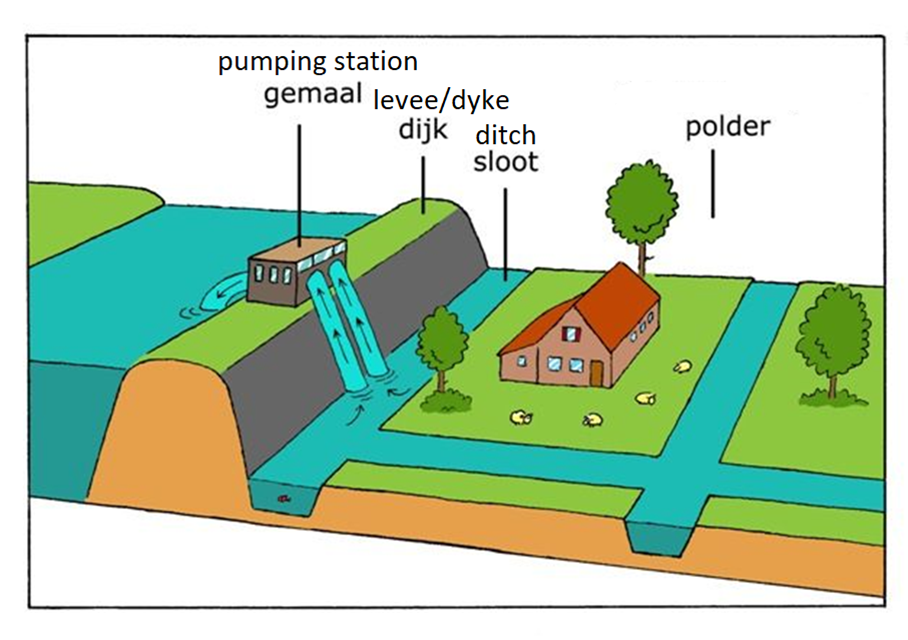

This is done by a polder pumping station - or _poldergemaal_ in Dutch. 
This is a small building with a big pump that can remove water from the polder to canals that eventually transfer it to sea.


If the polder is emptied too much, the land in the polder has too little water for nature and farmers. Therefore, an ideal water level is determined by the water board. The pumping station is managed in such way, that this level is followed as closely as possible, by turning the pumps on and off. This resembles the working of for example an oven or central heating in a house.

_This is what a polder pumping station looks like, although it comes in many shapes and sizes._

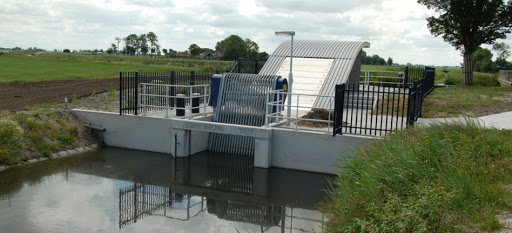

_Schematic pumping station._

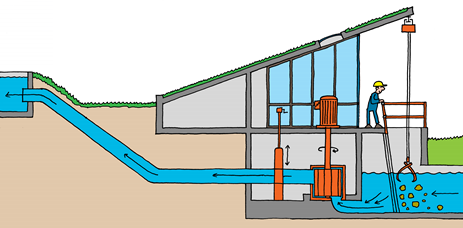

In this tutorial, you will create a control system which tries to follow this ideal water level as closely as possible, while it's raining in the polder. This rain is generated randomly. The water level we're aiming at is 0.5 m. 


## (Deep) Reinforcement learning
We'll be using a technique called deep reinforcement learning. Based on simulations, the method tries to decide what is the best action it can do. It uses so-called neural networks, which are originally based on the workings of human brains. These kinds of models have been used to create the best chess robots in the world and for the first time beat the best human in the game of Go. 

_A Neural Network_

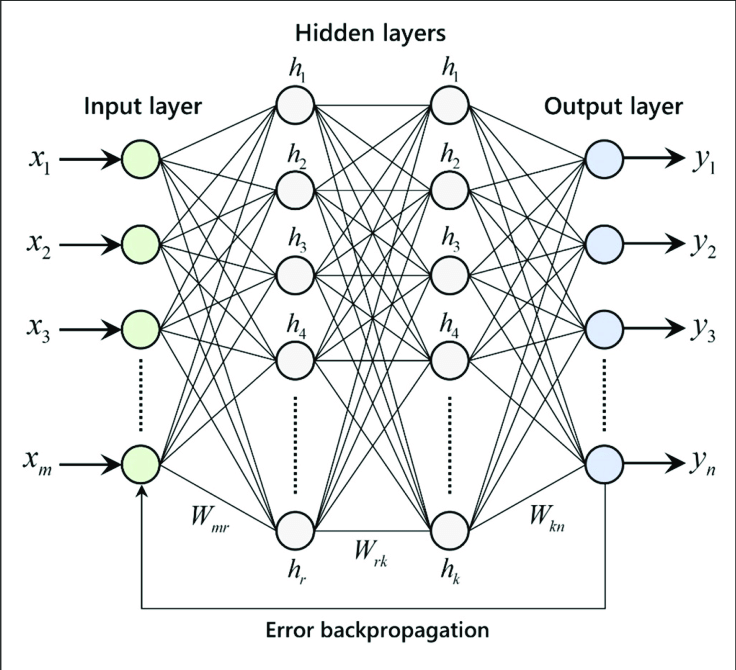


The model consists of a number of parts: 
- Environment: the world the agent interacts with
- Agent: the model that alters the environment
- State: the state the world (environment) is in at a moment
- Reward: this is important; in order to learn to do what we want, the system should deliver rewards. These should be high when the model does what we want it to do, and low when it's doing things that we don't want it to do.

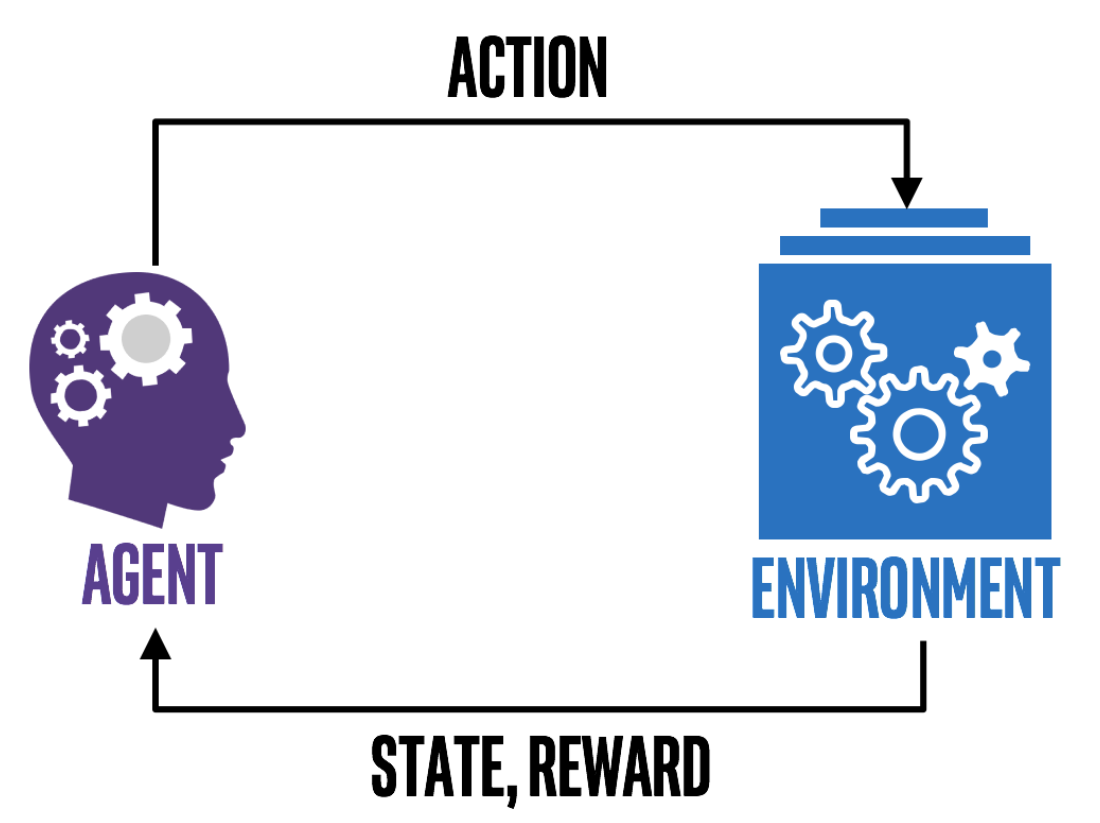

## Reward
In this tutorial, the first question you will try to solve, is the reward function. You will try to make a function that is high when the water level is around the level we want (so 0.5 m) and low when the water level is 

## Python
The programming is done in the programming called Python. This is a relatively easy programming language and is widely used by data scientist.

## Hints

In [2]:
import hints

In [1]:
!pip install tensorforce

     |████████████████████████████████| 307kB 6.8MB/s eta 0:00:01
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 2.2MB 9.7MB/s 
     |████████████████████████████████| 1.6MB 33.7MB/s 
     |████████████████████████████████| 10.3MB 37.0MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656452 sha256=85756c33ff60f80e1f53315b3ac625f5b7304535884ec29bc16d7abd705806bb
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
Successfully built gym
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Suc

In [1]:
from tensorforce.environments import Environment
from tensorforce.agents import Agent
import numpy as np
import plotly.express as px
import pandas as pd
from random import uniform

In [3]:
class PolderEnvironment(Environment):
    """Simple polder environment. It is a polder with a single pump attached to it. 
    If the pump is activated, the waterlevel in the polder will lower. 
    Rainfall will cause the waterlevel in the polder to rise. 
    The amount of rainfall is random. 
    The goal will be to keep the waterlevel between 0.0 and 1.0m NAP and to keep this up for at least 100 timesteps.
    """
    def __init__(self):
        super().__init__()
        self.water_level = np.random.uniform(low=0.0, high=1.0, size=(1,))

    def states(self):
        return dict(type='float', shape=(1,),  min_value=0.0, max_value=1.0)

    def actions(self):
        return dict(type='int', num_values=2)

    # Optional, should only be defined if environment has a natural maximum
    # episode length
    def max_episode_timesteps(self):
        return 500


    # Optional
    def close(self):
        super().close()


    def reset(self):
        """Reset state."""
        self.timestep = 0
        self.water_level = np.random.uniform(low=0.0, high=1.0, size=(1,))
        return self.water_level


    def response(self, action):
        """Respond to an action."""
        return self.water_level - (action * 0.2)


    def reward_compute(self):
        delta = abs(self.water_level - 0.5)
        if delta < 0.1:
            return 0.0
        else:
            return -delta[0] + 0.1

        # Goal water level = 0.5 [If water level = 0.5; penalty = 0]
        # Tip 1: this means that 'ideal water level' - 0.5 = 0 = penalty
        # If it is not ideal, this penalty should be higher
        
        # take as input the water level
        # give a penalty which you find logical; how far of your goal are you?
        # Note that a power is written as ** instead of ^ in Python

        # Penalty should always be larger than 0, depending on 

        penalty = ... [something with self.water_level]

        # teken het eerst eens uit!
        penalty = abs(self.water_level - 0.5)
        penalty = (self.water_level-0.5)**2
        
        if self.water_level < 0.5:
          penalty 
        
        return -penalty
        # TODO 0 weghalen

    def rain(self):
        return uniform(0.0,0.2)

    # back-up
    def terminal(self):
        if self.water_level > 1.0 or self.water_level < 0.0:
            return True 
        return False

    def execute(self, actions):
        ## Check the action is either 0 or 1 -- pump on or off.
        assert actions == 0 or actions == 1

        ## Increment timestamp
        self.timestep += 1
        
        ## Update the current_temp
        self.water_level = self.response(actions)
        self.water_level += self.rain()

        ## Compute the reward
        reward = self.reward_compute()

        ## The only way to go terminal is to exceed max_episode_timestamp.
        ## terminal == False means episode is not done
        ## terminal == True means it is done.
        terminal = self.terminal()
        
        return self.water_level, terminal, reward

TODO:
- Create an environment
- Create an agent.
- Train the agent


In [4]:
environment = environment = Environment.create(
    environment=PolderEnvironment,
    max_episode_timesteps=500)

In [5]:
agent = Agent.create(
    agent='tensorforce', environment=environment, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=1)
)

In [ ]:
for _ in range(200):
    states = environment.reset()
    terminal = False
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = environment.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)

Test your agent here:

In [ ]:
### Initialize
environment.reset()

## Creation of the environment via Environment.create() creates
## a wrapper class around the original Environment defined here.
## That wrapper mainly keeps track of the number of timesteps.
## In order to alter the attributes of your instance of the original
## class, like to set the initial temp to a custom value, like here,
## you need to access the `environment` member of this wrapped class.
## That is why you see the way to set the current_temp like below.
environment.water_level = np.array([0.5])
states = environment.water_level

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.water_level[0]]
while not terminal:
    actions, internals = agent.act(states=states, internals=internals, independent=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]
    
### Plot the run
df = pd.Series(temp).rename('water level')
fig = px.line(df, title='Reinforcement learning poldergemaal')
fig.show()

In [ ]:
### Initialize
environment.reset()
environment.water_level = np.random.uniform(low=0.0, high=1.0, size=(1,))
states = environment.water_level

internals = agent.initial_internals()
terminal = False

### Run an episode
temp = [environment.water_level[0]]
while not terminal:
    actions, internals = agent.act(states=states, internals=internals, independent=True)
    states, terminal, reward = environment.execute(actions=actions)
    temp += [states[0]]

df = pd.Series(temp).rename('water level')
fig = px.line(df, x=df.index, y='water level', title='Reinforcement learning poldergemaal')
fig.update_yaxes(range = [0,1])

NameError: ignored

In [ ]:
df

0      0.633982
1      0.557828
2      0.531648
3      0.437988
4      0.582085
         ...   
496    0.618928
497    0.584687
498    0.561225
499    0.426904
500    0.520207
Name: water level, Length: 501, dtype: float64

In [ ]:
fig = px.line(df, x=df.index, y='water level', title='Reinforcement learning poldergemaal')
fig.update_yaxes(range = [0,1])